## Exploring the data

In [1]:
!ls data

BLCA_gene_exp.csv  GBM_gene_exp.csv   KIRC_gene_exp.csv
CESC_gene_exp.csv  HNSC_gene_exp.csv  LGG_gene_exp.csv


In [2]:
!head data/BLCA_gene_exp.csv | cut -f 1-5 -d,

,ARHGEF10L,HIF3A,RNF17,RNF10
TCGA-DK-A6B5-01,0.4117620359741987,-0.3148472342501319,-0.1461397580531456,1.1593856497132908
TCGA-5N-A9KM-01,-0.6746583576834817,-0.2679812496078634,-0.19720275994022124,1.0863557753657629
TCGA-BT-A0S7-01,-1.3493745400591655,-0.2332996641802055,-0.19720275994022124,0.0219843732412443
TCGA-FD-A43Y-01,-1.0507029831702035,-0.34159387294391247,0.18682339500210077,1.0227636684940713
TCGA-YF-AA3L-01,0.6833352604487828,-0.30331177068307585,-0.04053726051998096,0.5410599210274938
TCGA-DK-A6B6-01,2.157764202249689,-0.3362737264515328,-0.017858511700927705,-0.6164628181989142
TCGA-KQ-A41N-01,-0.8404802099790415,-0.2950907020383703,-0.19720275994022124,-0.88898701245783
TCGA-R3-A69X-01,0.03861393109901789,0.006433151914866945,-0.19720275994022124,-0.34414055183575937
TCGA-FD-A5BT-01,-0.9283780034358554,3.2485160512666327,-0.19720275994022124,-0.8879428649550184


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE


In [4]:
df_list = []
labels = []
for file in os.listdir("data/"):
    if file.endswith('.csv'):
        label = file.split('_')[0]
        labels.append(label)
        
        df = pd.read_csv('data/'+file, index_col=0)
        df['cancer_type'] = label #add a column with cancer type 
        df_list.append(df)
        print(f' Shape of {label} DF: {df.shape}')


 Shape of KIRC DF: (606, 20531)
 Shape of GBM DF: (518, 12043)
 Shape of HNSC DF: (566, 20531)
 Shape of CESC DF: (307, 20531)
 Shape of LGG DF: (529, 20531)
 Shape of BLCA DF: (426, 20531)


We can see there is an imbalance in the data for each type of cancer and GBM has only a little over half the number of genes.

## Preprocessing and Exploratory Data Analysis

In [5]:
df_list[0]

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,cancer_type
TCGA-B0-5402-01,-0.613869,3.907610,-0.092480,-0.428222,-0.732195,-0.228208,-1.147002,-0.799435,-0.089858,-0.114388,...,0.710281,-0.201891,0.153669,0.068967,-0.449808,0.059252,-0.063909,0.328185,1.578171,KIRC
TCGA-CJ-4634-01,1.150781,0.451041,-0.092480,-0.582534,-0.153104,0.172521,0.046365,-0.227903,0.352889,-0.179009,...,-0.638642,0.265801,-0.645776,0.446156,0.172093,0.519404,-0.683210,-0.652565,-0.989972,KIRC
TCGA-B0-4828-01,0.450394,0.096415,-0.061711,0.075810,-0.529892,-0.497759,1.062191,-0.057001,0.865147,-0.053080,...,-0.635284,-0.628036,1.913753,1.137948,0.171959,-0.565262,0.371532,-0.924489,-0.475239,KIRC
TCGA-CZ-5452-11,1.397206,0.478936,-0.092480,2.427314,0.385003,-0.140100,0.429928,-0.554670,-0.415514,-0.501084,...,1.565750,-0.550874,-0.625024,-0.991979,-0.875701,-0.970794,-0.536241,2.851699,-0.766554,KIRC
TCGA-B4-5835-01,-1.127536,-0.586795,-0.092480,-0.651031,-2.056976,1.756855,-1.152287,-0.954072,-0.415514,-0.575197,...,1.060696,-0.711862,-0.377746,-1.412339,-1.560296,-1.259452,1.117531,-0.983725,0.465267,KIRC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4784-01,-0.911786,-0.224480,-0.092480,-0.269673,1.034742,-0.471411,-0.849035,2.180480,-0.415514,0.432103,...,-0.102417,-0.350022,-0.117953,-1.002027,1.424825,1.072323,-0.940161,1.250041,0.313779,KIRC
TCGA-BP-4326-01,-1.441992,-0.208324,-0.092480,-0.091613,-0.022957,-0.549953,-0.768373,-0.805816,-0.415514,0.041410,...,-0.415023,-0.834493,0.422114,-0.586836,0.119022,1.166012,-0.985150,0.526397,0.673991,KIRC
TCGA-BP-5183-01,1.584225,-0.414457,-0.092480,-0.489489,-0.203395,0.055019,0.495772,-0.864009,1.162661,-0.454486,...,-0.741576,0.427264,-0.135147,1.441242,-0.379014,-0.635599,0.727452,-0.312704,-0.667787,KIRC
TCGA-CZ-4858-01,-1.771377,-0.572639,-0.092480,1.525178,-0.562746,0.846221,0.871250,-0.643763,-0.415514,12.008514,...,-0.753964,0.472820,-0.645776,-0.690071,-0.522503,-1.033333,-0.434594,-1.191037,0.514227,KIRC


In [6]:
labels

['KIRC', 'GBM', 'HNSC', 'CESC', 'LGG', 'BLCA']

Data is z-score normalized as given in the data description.

In [7]:
summary_stats = df_list[0].describe()
summary_stats

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
count,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,...,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02
mean,-3.363646e-16,1.450985e-16,4.909897e-17,-4.821959e-16,-3.810666e-17,1.612205e-16,2.447620e-16,8.500718e-17,9.526666e-17,5.276307e-17,...,4.396923e-17,-2.345026e-17,3.136472e-16,-3.810666e-17,9.966359e-17,-3.429600e-16,5.569436e-17,-1.612205e-16,4.250359e-17,-3.253723e-16
std,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,...,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00
min,-2.271841e+00,-6.459548e-01,-9.247980e-02,-2.190582e+00,-2.056976e+00,-2.030416e+00,-2.086317e+00,-1.005313e+00,-4.155136e-01,-6.760830e-01,...,-1.694140e-01,-7.690484e-01,-1.596052e+00,-6.457763e-01,-2.795868e+00,-1.682022e+00,-1.350690e+00,-1.571467e+00,-1.218395e+00,-1.563071e+00
25%,-7.027435e-01,-4.575381e-01,-9.247980e-02,-6.754477e-01,-5.682449e-01,-4.740825e-01,-6.878786e-01,-5.919980e-01,-4.155136e-01,-4.016968e-01,...,-1.694140e-01,-6.027938e-01,-6.125888e-01,-6.170579e-01,-6.141036e-01,-5.690006e-01,-7.199150e-01,-5.737941e-01,-7.123843e-01,-5.713355e-01
50%,-9.518621e-02,-2.597806e-01,-9.247980e-02,-3.054048e-01,-6.842138e-02,-1.195395e-01,-1.766619e-01,-2.630672e-01,-4.155136e-01,-1.963531e-01,...,-9.174044e-02,-4.101084e-01,-1.220995e-01,-4.023013e-01,-9.582614e-02,-1.310739e-01,-2.016797e-01,-2.477684e-01,-2.511274e-01,-1.768746e-01
75%,5.649278e-01,7.352843e-02,-9.247980e-02,5.235957e-01,4.274360e-01,2.913072e-01,4.532590e-01,2.736034e-01,7.958369e-02,8.744978e-02,...,1.727251e-02,1.682409e-01,4.138173e-01,2.877428e-01,4.811325e-01,3.894406e-01,4.977574e-01,3.326876e-01,4.466715e-01,3.579711e-01
max,4.285713e+00,1.368242e+01,2.190922e+01,4.721814e+00,9.226470e+00,1.559750e+01,5.427266e+00,9.744529e+00,1.440080e+01,1.212609e+01,...,2.424242e+01,6.140606e+00,1.228388e+01,7.780909e+00,6.843142e+00,1.259812e+01,5.835310e+00,1.267937e+01,4.943308e+00,1.270433e+01


We see the means are very close to zero and SD = 1

### Merging datasets to get a global view of the data

We merge the datasets based on common features present in all the datasets - intersecting genes

In [8]:
#find intersecting genes
common_genes = set(df_list[0].columns)
for df in df_list[1:]:
    common_genes &= set(df.columns)

In [9]:
common_genes

{'GHSR',
 'FA2H',
 'ARPC1A',
 'TP53',
 'PUF60',
 'THBS1',
 'NRIP2',
 'GLTP',
 'JMJD4',
 'FXYD7',
 'TSPAN6',
 'ATP5I',
 'ODAM',
 'C10orf76',
 'CHST12',
 'SPATA6',
 'GTPBP1',
 'SNCA',
 'HIST1H2AK',
 'UQCRC1',
 'APBA3',
 'CHN1',
 'ARMC9',
 'CAPN10',
 'SLC12A7',
 'TRAPPC3',
 'GNAZ',
 'NSD1',
 'TIMM13',
 'CSF2',
 'CTNNBIP1',
 'RRAS',
 'PRSS16',
 'CCDC69',
 'UCHL3',
 'DIO1',
 'TCL1B',
 'TRPC4AP',
 'MRPL22',
 'SMURF2',
 'TRIM66',
 'CST5',
 'CPSF6',
 'CSTA',
 'PLEKHH3',
 'RPL37',
 'NUPR1',
 'BRCA1',
 'NFYA',
 'PTPN3',
 'SLC35A5',
 'PAK4',
 'PTPN9',
 'TAF12',
 'TRPV2',
 'RNF31',
 'ZNF132',
 'MGAT2',
 'NDUFAB1',
 'ALMS1',
 'PANK2',
 'CD55',
 'CSTF2',
 'ZNF91',
 'ICAM1',
 'MRPL44',
 'ARHGEF4',
 'EFNA1',
 'BBC3',
 'SLC4A8',
 'KCNJ4',
 'PCNA',
 'SUCLA2',
 'SAPS3',
 'MDFI',
 'ESPL1',
 'DPT',
 'SEMA3D',
 'SLC17A6',
 'ARL6IP4',
 'GAMT',
 'ELMO2',
 'RNF41',
 'FGF1',
 'FUCA1',
 'VEGFA',
 'TRIM31',
 'PML',
 'MYL1',
 'UPK3B',
 'CLCA1',
 'TRIM58',
 'ARHGAP28',
 'DDX41',
 'ST20',
 'COL1A2',
 'ANKRD28',
 'ZM

In [10]:
len(common_genes)

11313

In [11]:
#merge data on common genes
merged_df = pd.concat([df[list(common_genes)] for df in df_list], axis=0)

print(f"Merged Data Shape: {merged_df.shape}")
print(merged_df.head())

#save merged dataframe
merged_df.to_csv("data/merged_counts.csv")

Merged Data Shape: (2952, 11313)
                     GHSR      FA2H    ARPC1A      TP53     PUF60     THBS1  \
TCGA-B0-5402-01 -0.143705 -0.392405  0.270800 -1.549548 -0.920463 -0.380181   
TCGA-CJ-4634-01 -0.143705 -0.399327 -0.589970 -0.197029 -0.738981  0.459510   
TCGA-B0-4828-01 -0.143705 -0.253218  0.849186 -0.349016  0.403229 -0.272654   
TCGA-CZ-5452-11 -0.143705  0.779569 -0.882783 -1.140471  0.084329  0.158971   
TCGA-B4-5835-01 -0.143705  1.858492  0.933702 -1.275350  0.295178 -1.385379   

                    NRIP2      GLTP     JMJD4     FXYD7  ...    ADAM29  \
TCGA-B0-5402-01 -0.760495 -0.635172 -0.100552 -0.474161  ... -0.254231   
TCGA-CJ-4634-01 -0.895246 -0.414213 -0.239610  0.642701  ... -0.411047   
TCGA-B0-4828-01 -0.070618 -0.186798  0.513287 -0.085926  ...  1.243863   
TCGA-CZ-5452-11 -1.082460  2.320584 -0.677916 -0.532627  ... -0.423215   
TCGA-B4-5835-01 -1.264084 -0.588028  3.389564 -0.061407  ... -0.439743   

                   DNAJB1   ADAMTS6      WWC1  

### Normalization

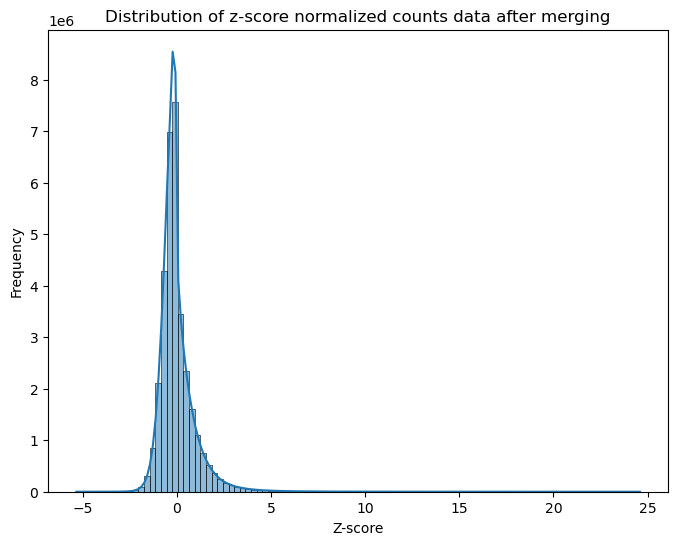

In [12]:
#Checking the distribution of merged data
plt.figure(figsize=(8, 6))
sns.histplot(merged_df.loc[:, merged_df.columns != "cancer_type"].values.flatten(), bins=100, kde=True)
plt.title("Distribution of z-score normalized counts data after merging")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.show()

- The orginal data is z-score normalized as seen from the above plot, hence no normalization is required.
- Re-normalization after merging is not required as the data still follows standard normal distribution

### Data Imputation

In [13]:
#check for missing values
merged_df.isna().any()

GHSR      False
FA2H      False
ARPC1A    False
TP53      False
PUF60     False
          ...  
SYNJ1     False
FOXO1     False
PCNP      False
EIF1      False
FLVCR2    False
Length: 11313, dtype: bool

In [14]:
np.where(merged_df.isna().any())

(array([], dtype=int64),)

There are no missing values, hence data imputation is not required.

### Class rebalancing using SMOTE

In [15]:
merged_df['cancer_type'].value_counts()

cancer_type
KIRC    606
HNSC    566
LGG     529
GBM     518
BLCA    426
CESC    307
Name: count, dtype: int64

<Axes: xlabel='Cancer Type', ylabel='Number of Samples'>

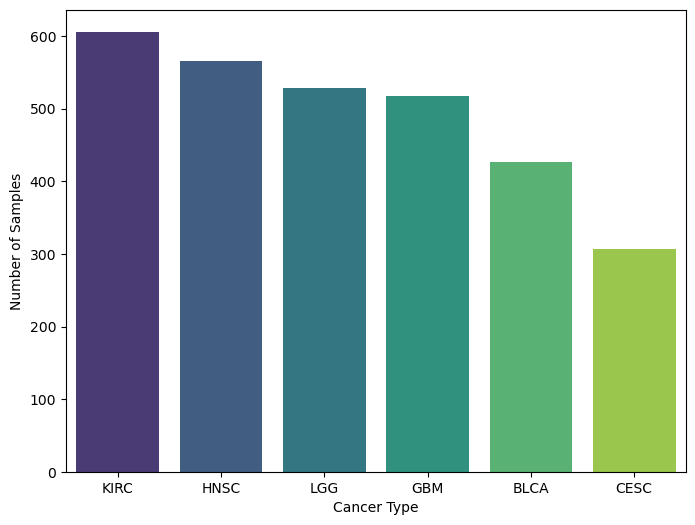

In [16]:
samples_before = merged_df['cancer_type'].value_counts()

before_smote = pd.DataFrame({
    "Cancer Type": samples_before.index,
    "Number of Samples": samples_before.values
})

plt.figure(figsize=(8, 6))
sns.barplot(x="Cancer Type", y="Number of Samples", data=before_smote, hue='Cancer Type', palette="viridis")

As we can see the classes are very imbalanced with CESC having only 307 datapoints where as KIRC has 606 datapoints. To avoid the model being baised towards over-represented data, we can use SMOTE(Synthetic Minority Oversampling Technique) which synthetically creates datapoints for under-represented classes.

In [17]:
#separate datapoints and labels
X = merged_df.loc[:, merged_df.columns != "cancer_type"]
y = merged_df["cancer_type"]

In [18]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_smote = pd.DataFrame(X_resampled, columns=X.columns)
y_smote = pd.DataFrame(y_resampled, columns=["cancer_type"])

smote_df = pd.concat([X_smote, y_smote], axis=1)

In [19]:
smote_df['cancer_type'].value_counts()

cancer_type
KIRC    606
GBM     606
HNSC    606
CESC    606
LGG     606
BLCA    606
Name: count, dtype: int64

<Axes: xlabel='Cancer Type', ylabel='Number of Samples'>

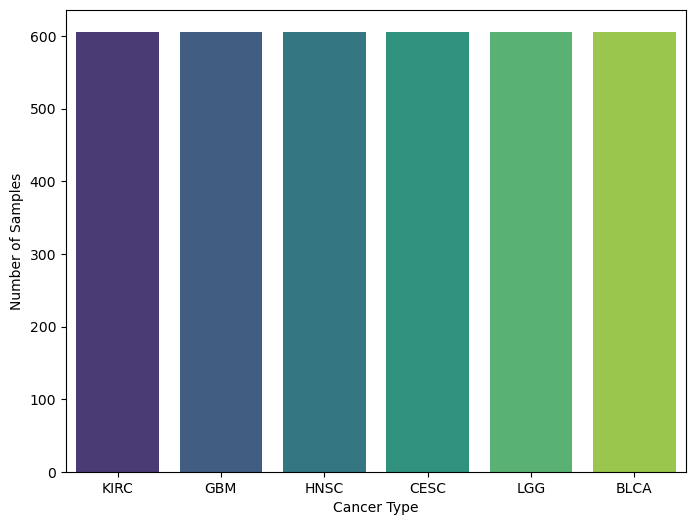

In [20]:
samples_after = smote_df['cancer_type'].value_counts()

after_smote = pd.DataFrame({
    "Cancer Type": samples_after.index,
    "Number of Samples": samples_after.values
})

plt.figure(figsize=(8, 6))
sns.barplot(x="Cancer Type", y="Number of Samples", data=after_smote, hue='Cancer Type', palette="viridis")

### Feature engineering and Dimensionality reduction

A common step in RNAseq analyses is to find highly variable genes. Typically, the top 1000-10000 highly variable genes are used for downstream analyses. We'll use 5000 highly variable genes.

In [21]:
top_genes = X_smote.var(axis=0).nlargest(5000).index
X_hvg = X_smote[top_genes]
y_hvg = y_smote.values[:, 0]

In [22]:
X_hvg

,MAGEB1,FSHR,IL3,CYP3A4,CRYBB3,MYL4,ADRB3,PMP2,PAGE1,GK2,...,NEIL1,TSFM,ELOVL4,PTGER4,RBP3,PDGFC,GNB1L,FMR1,EMID1,C14orf135
0,-0.064513,-0.179857,-0.206956,-0.076612,-0.143307,-0.417568,-0.413737,-0.262871,-0.042003,-0.199312,...,-0.902053,-0.224649,-0.243452,-0.802696,-0.285669,-0.005129,-0.563166,-0.167055,0.378669,0.145343
1,-0.064513,-0.179857,-0.206956,-0.094389,-0.095009,0.232305,-0.027568,-0.262871,-0.042003,-0.199312,...,-0.290985,-0.563237,-0.242351,-0.852675,-0.285669,0.678899,-0.710237,-0.641696,-0.478930,0.163877
2,-0.064513,-0.179857,-0.206956,-0.109060,-0.102317,-0.765819,-0.413737,-0.262871,-0.042003,-0.199312,...,-0.457714,0.497745,-0.228892,-0.792896,-0.285669,-0.490260,-0.219128,0.274402,-0.390020,0.011180
3,-0.064513,-0.046662,-0.206956,-0.114829,-0.144820,-0.877148,0.682419,-0.262871,-0.042003,-0.199312,...,-0.130499,0.596715,-0.334113,0.058060,-0.285669,-0.720228,-0.142494,0.067793,-0.743749,0.666000
4,-0.064513,0.035158,-0.206956,0.452143,-0.114303,-0.858182,-0.301389,-0.262871,-0.042003,-0.199312,...,-0.943613,1.064943,0.150171,-0.947218,0.178635,-0.131974,0.155132,1.908157,-0.351933,0.043072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,-0.110521,-0.410238,0.888783,-0.066203,0.452282,0.058008,-0.094941,0.231922,-0.132873,-0.440943,...,1.139843,-0.093472,1.207399,0.037717,-0.251555,-0.336317,-0.191758,-0.475333,0.432852,-1.220784
3632,-0.110521,2.894941,-0.173352,-0.051397,-0.282620,-0.156171,0.609424,-0.543005,-0.132873,0.192979,...,-0.382634,-0.141907,1.902326,-0.392515,0.100807,0.867928,-0.966612,0.587243,-0.424883,0.046218
3633,-0.110521,-0.410238,-0.173352,-0.067088,-0.543997,-0.058863,0.174306,-0.712574,-0.132873,-0.648575,...,0.242800,-0.153956,0.273923,-0.521982,0.530053,0.215228,-0.660904,0.564724,-0.261889,0.840391
3634,-0.110521,-0.410238,-0.173352,-0.022032,0.646172,0.284504,0.514918,-0.534226,-0.132873,-0.648575,...,-0.111786,0.948557,-0.154386,0.975151,-0.673189,0.177186,2.155424,-1.357120,1.930229,-0.584499


##### Applying PCA for dimensionality reduction

In [23]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_hvg)

pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df["cancer_type"] = smote_df["cancer_type"].values

In [24]:
#checking the variance explained by each PC
pca.explained_variance_ratio_

array([0.0921476 , 0.04334929, 0.03945803, 0.03540436, 0.02964184,
       0.02383108, 0.02137417, 0.02018638, 0.01620336, 0.0149556 ,
       0.01297194, 0.01196983, 0.01013865, 0.00940064, 0.00922935,
       0.00848709, 0.00816389, 0.00759101, 0.00663953, 0.00631507,
       0.00601554, 0.00580178, 0.00559512, 0.00549241, 0.00498595,
       0.00464955, 0.00457251, 0.00454962, 0.00430287, 0.00419953,
       0.0040951 , 0.00399253, 0.00391895, 0.00377979, 0.0036587 ,
       0.00359168, 0.00347962, 0.0034579 , 0.00339886, 0.00333449,
       0.00318256, 0.00307713, 0.00301666, 0.00294107, 0.00291241,
       0.00287198, 0.00271686, 0.00268326, 0.00267186, 0.00261227])

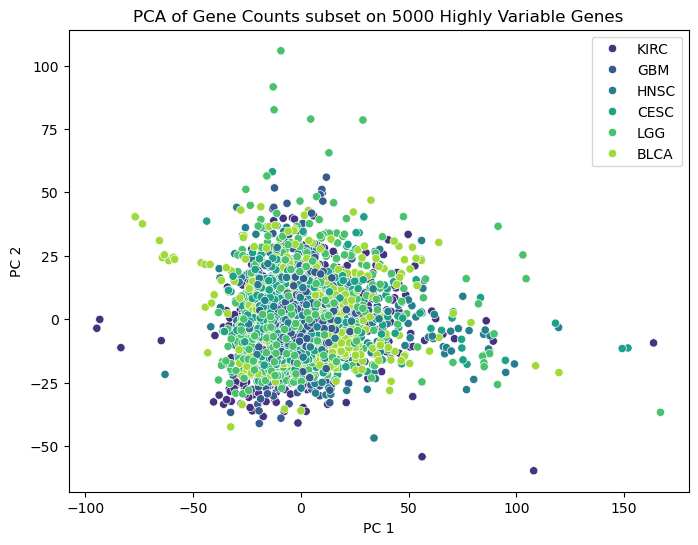

In [25]:
#visualize PCA plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="cancer_type", data=pca_df, palette="viridis")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of Gene Counts subset on 5000 Highly Variable Genes")
plt.legend()
plt.show()

Given the variance explained by each PC is very low, we don't see any clear clustering with PCA. Next, we applied TSNE to try non-linear DR

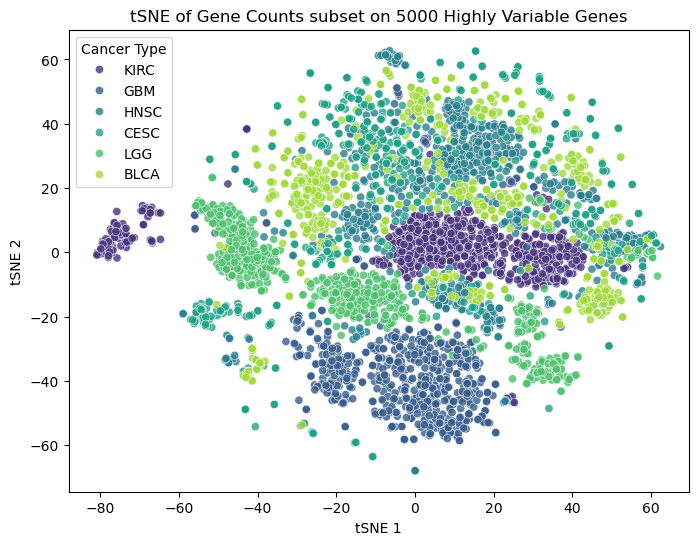

In [26]:
tsne = TSNE(n_components=2)
tsne_obj = tsne.fit_transform(X_hvg.values)

tsne_df = pd.DataFrame(tsne_obj, columns=["tSNE1", "tSNE2"])
tsne_df["cancer_type"] = smote_df["cancer_type"].values

#visualize t-SNE plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="cancer_type", data=tsne_df, palette="viridis", alpha=0.8)
plt.title("tSNE of Gene Counts subset on 5000 Highly Variable Genes")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.legend(title="Cancer Type")
plt.show()

We see much better clustering with tSNE compared with PCA.

## Support Vector Classifier Model Fitting

In [27]:
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_hvg, test_size=0.2, random_state=42, stratify=y_hvg)

In [28]:
#train and fit the SVC with radial kernel
svm = SVC(kernel="rbf", C=1, random_state=42)
svm.fit(X_train, y_train)

SVC(C=1, random_state=42)

In [29]:
y_pred = svm.predict(X_test)

## Metrics and Evaluation

In [30]:
#with 5k HVGs
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {f1:.4f}")

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 0.9492
Macro F1 Score: 0.9491
Balanced Accuracy: 0.9492
              precision    recall  f1-score   support

        BLCA       0.91      0.93      0.92       121
        CESC       0.92      0.92      0.92       121
         GBM       1.00      0.99      1.00       121
        HNSC       0.92      0.89      0.90       122
        KIRC       0.97      0.98      0.98       122
         LGG       0.98      0.98      0.98       121

    accuracy                           0.95       728
   macro avg       0.95      0.95      0.95       728
weighted avg       0.95      0.95      0.95       728



We can see from the above evaluation, the model achieves a 94.51% accuracy with overall macro F1 score of 0.95.

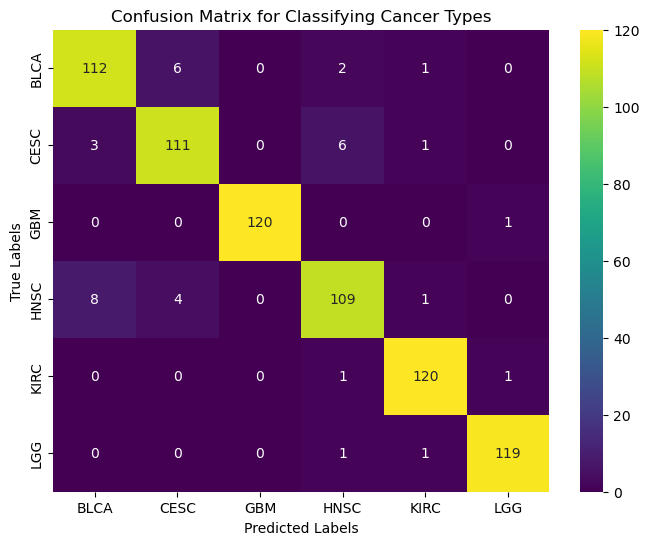

In [31]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Classifying Cancer Types")
plt.show()

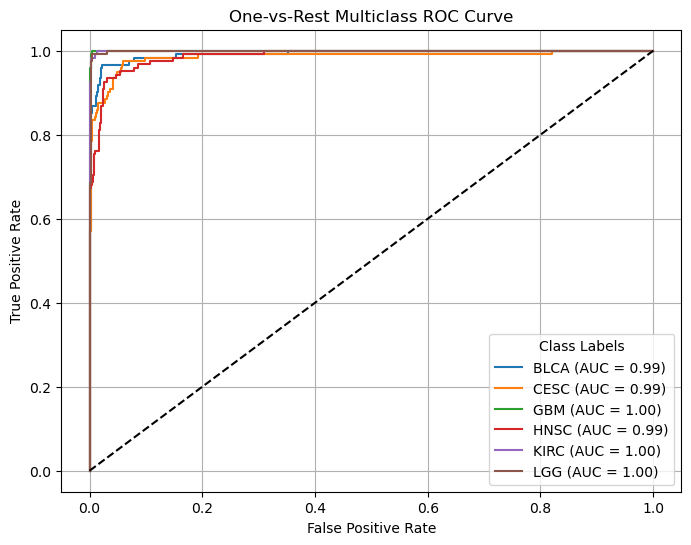

In [32]:
#create one-hot encoding for multi-class labels
y_bin = label_binarize(y_train, classes=np.unique(y_train))
class_labels = np.unique(y_train)
n_classes = y_bin.shape[1]

#use SVC to get probability scores for each class
svm = OneVsRestClassifier(SVC(kernel="rbf", C=1, probability=True, random_state=42))
svm.fit(X_train, y_bin)

y_score = svm.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=class_labels)

#visualize
plt.figure(figsize=(8, 6))

for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

#reference line
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest Multiclass ROC Curve")
plt.legend(title="Class Labels")
plt.grid()
plt.show()

## Comparative analysis of hyperparameters

We also performed hyperparameter tuning for different values of hyperparameters 
- **number of highly variable genes selected** - more genes, more accurate classification but takes more time. less genes, faster but effects accuracy.
- **regularization parameter C in SVC** - uses squared L2 penalty. C is inversely proportional to the strength of the regularization. So, smaller C means larger penalty leading to better generalization and larger C means smaller penalty leading to overfitting


Comparison of SVM Performance with PCA:
   # HVG  Accuracy  F1_Score
0    500  0.913462  0.913950
1   1000  0.923077  0.923105
2   2000  0.940934  0.940950
3   5000  0.949176  0.949245
4   7500  0.957418  0.957396
5  10000  0.957418  0.957398


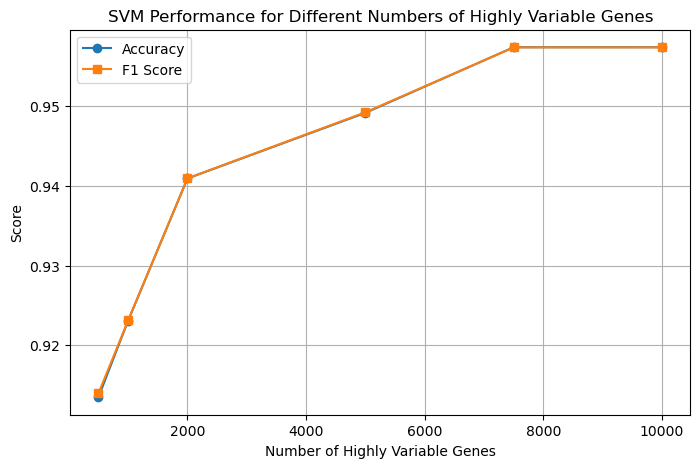

In [33]:
#different number of HVGs
hvg = [500, 1000, 2000, 5000, 7500, 10000]
results = []

for n in hvg:
    top_genes = X_smote.var(axis=0).nlargest(n).index 

    X_hvg = X_smote[top_genes]
    y_hvg = y_smote.values[:, 0]

    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_hvg)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_hvg, test_size=0.2, random_state=42, stratify=y_hvg)

    svm_model = SVC(kernel="rbf", C=1, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append([n, accuracy, f1])

results_df = pd.DataFrame(results, columns=["# HVG", "Accuracy", "F1_Score"])

print("\nComparison of SVM Performance with PCA:")
print(results_df)

#visualize
plt.figure(figsize=(8, 5))
plt.plot(results_df["# HVG"], results_df["Accuracy"], marker="o", label="Accuracy")
plt.plot(results_df["# HVG"], results_df["F1_Score"], marker="s", label="F1 Score")
plt.xlabel("Number of Highly Variable Genes")
plt.ylabel("Score")
plt.title("SVM Performance for Different Numbers of Highly Variable Genes")
plt.legend()
plt.grid(True)
plt.show()

As we can see, adding more features increases the accuracy of the model but takes more time for training.

   C_Value  Accuracy  F1_Score
0     0.01  0.424451  0.353446
1     0.10  0.765110  0.768603
2     1.00  0.946429  0.946554
3    10.00  0.954670  0.954782
4   100.00  0.953297  0.953439


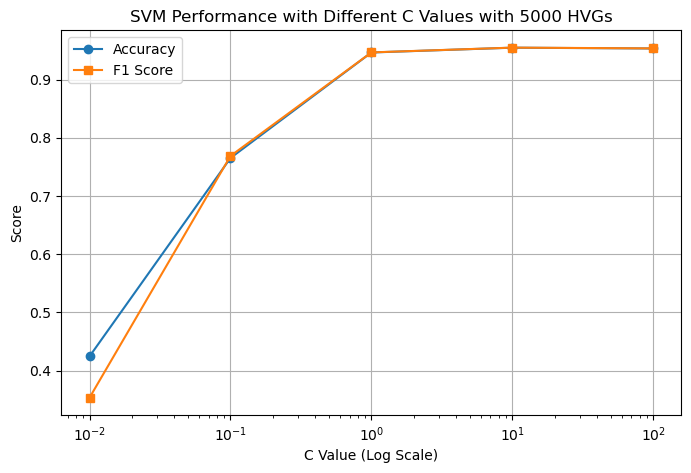

In [34]:
#different C values to test
C_values = [0.01, 0.1, 1, 10, 100]
results = []

top_genes = X_smote.var(axis=0).nlargest(5000).index

X_hvg = X_smote[top_genes]
y_hvg = y_smote.values[:, 0]

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_hvg)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_hvg, test_size=0.2, random_state=42, stratify=y_hvg)

for c in C_values:
    svm_model = SVC(kernel="rbf", C=c, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append([c, accuracy, f1])

results_df = pd.DataFrame(results, columns=["C_Value", "Accuracy", "F1_Score"])
print(results_df)

#visualize
plt.figure(figsize=(8, 5))
plt.plot(results_df["C_Value"], results_df["Accuracy"], marker="o", label="Accuracy")
plt.plot(results_df["C_Value"], results_df["F1_Score"], marker="s", label="F1 Score")
plt.xscale("log")
plt.xlabel("C Value (Log Scale)")
plt.ylabel("Score")
plt.title(f"SVM Performance with Different C Values with 5000 HVGs")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the plot above, from 1, the performance of the model plateaues.

## Comparative analysis of different number of HVGs used

In [40]:
#differnt values of HVGs
gene_counts = [500, 1000, 2000, 5000, 7500, 10000]
accuracies = []
f1_scores = []

for n in gene_counts:
    top_genes = X_smote.var(axis=0).nlargest(n).index
    X_hvg = X_smote[top_genes]
    y_hvg = y_smote.values[:, 0]

    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_hvg)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_hvg, test_size=0.2, random_state=42, stratify=y_hvg)

    svm = SVC(kernel="rbf", C=1, random_state=42)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"{n} genes - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

500 genes - Accuracy: 0.9162, F1 Score: 0.9163
1000 genes - Accuracy: 0.9286, F1 Score: 0.9285
2000 genes - Accuracy: 0.9423, F1 Score: 0.9423
5000 genes - Accuracy: 0.9437, F1 Score: 0.9438
7500 genes - Accuracy: 0.9547, F1 Score: 0.9546
10000 genes - Accuracy: 0.9560, F1 Score: 0.9560


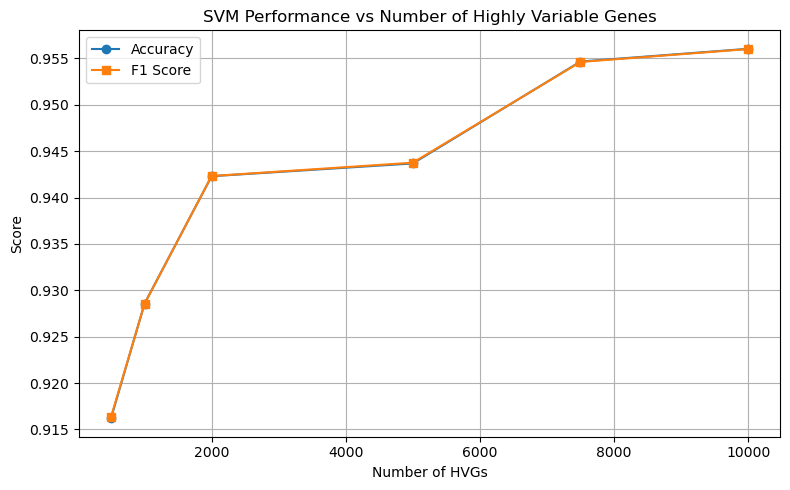

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(gene_counts, accuracies, marker='o', label='Accuracy')
plt.plot(gene_counts, f1_scores, marker='s', label='F1 Score')
plt.title("SVM Performance vs Number of Highly Variable Genes")
plt.xlabel("Number of HVGs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()